# Collegamento al drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Visualizzazione del dataset

In [ ]:
import numpy as np 
import pandas as pd

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Colab/train.tsv", sep="\t")
test = pd.read_csv("/content/drive/MyDrive/Colab/test.tsv", sep="\t")
train = train[['Phrase', 'Sentiment']]
train.head()

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


In [ ]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


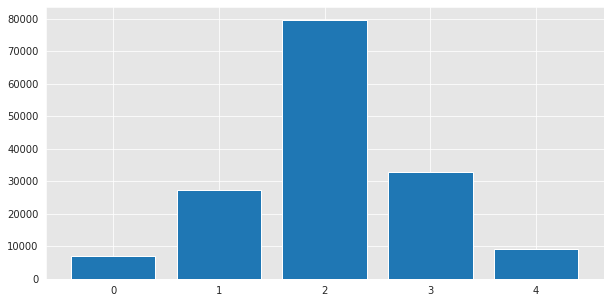

In [ ]:
import matplotlib.pyplot as plt
a = train.Sentiment.value_counts()
a = pd.DataFrame(a)
a['Rating'] = a.index
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(height='Sentiment', x='Rating', data=a)
plt.show()

# Splittaggio dataset in trainset e validation set (80%-20%)

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size = 0.2)
print(train.shape)
print(val.shape)

(124848, 2)
(31212, 2)


# Transformer e costruizione del modello

In [ ]:
! pip install -q transformers

     |████████████████████████████████| 4.4 MB 18.5 MB/s 
     |████████████████████████████████| 596 kB 50.6 MB/s 
     |████████████████████████████████| 6.6 MB 3.3 MB/s 
     |████████████████████████████████| 101 kB 5.3 MB/s 


In [ ]:
from transformers import AutoTokenizer
from transformers import RobertaTokenizer, TFRobertaModel
model_type = 'roberta'
pretrained_model_name = 'roberta-base'

#Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained(pretrained_model_name_or_path = pretrained_model_name)

#Roberta model
transformer_roberta_model = TFRobertaModel.from_pretrained(pretrained_model_name)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


The tokenizer returns a dictionary with 2 important itmes:

1.   input_ids are the indices corresponding to each token in the sentence.
2.   attention_mask indicates whether a token should be attended to or not.

Other tokeniser have "token_type_ids" that identifies which sequence a token belongs to when there is more than one sequence.

In [ ]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model

roberta = transformer_roberta_model.layers[0]

# Costruzione dell'input
input_ids = Input(shape=(52,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Usiamo roBERTa come modello che accetta l'input costruito in precedenza
roberta_model = roberta(inputs)[1]
dropout = Dropout(0.04)
pooled_output = dropout(roberta_model, training=False)

# Costruiamo il tipo di output del modello
Sentiments = Dense(5, name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# Costruiamo il modello unendo tutti i layer precedenti
model = Model(inputs=inputs, outputs=outputs, name='RoBERTa_MultiClass')

# Vediamo il nostro modello
model.summary()

Model: "RoBERTa_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 52)]              0         
                                                                 
 roberta (TFRobertaMainLayer  TFBaseModelOutputWithPoo  124645632
 )                           lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             52, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                

# Fase di training

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping

# Set an optimizer
optimizer = Adam(learning_rate=5e-05)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(train['Sentiment'])

# Tokenization del train set
x_train = tokenizer(
          text=train['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=52,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(val['Sentiment'])

# Tokenization del validation set
x_val = tokenizer(
          text=val['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=52,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_loss', patience = 2)
callback = [early_stopping]

In [ ]:
# Fit the model
history = model.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=64,
    epochs=5,
    verbose=1,
    callbacks=callback)

In [ ]:
model_json = model.to_json()
with open(f"/content/drive/MyDrive/Colab/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(f"/content/drive/MyDrive/Colab/model.h5")
print("Ho salvato il modello!")

Ho salvato il modello!


# Recupero del modello salvato


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from transformers import AutoTokenizer
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig  

model_loaded = tf.keras.Sequential()
# load json and create model
json_file = open('/content/drive/MyDrive/Colab/model.json', 'r')
model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(model_json)
# load weights into new model
model_loaded.load_weights("/content/drive/MyDrive/Colab/model.h5")
print("Loaded model from disk")


model_loaded.summary()

Loaded model from disk
Model: "RoBERTa_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 52)]              0         
                                                                 
 roberta (TFRobertaMainLayer  TFBaseModelOutputWithPoo  124645632
 )                           lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             52, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                         

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
# Set an optimizer
optimizer = Adam(learning_rate=5e-05)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model_loaded.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Valutazione del modello

In [ ]:
model_loaded.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Sentiment': y_val}
)

976/976 [==============================] - 5122s 5s/step - loss: 0.6521 - accuracy: 0.7291


In [ ]:
val_prediction = model_loaded.predict(
    x={'input_ids': x_val['input_ids']},
)

              precision    recall  f1-score   support

           0       0.58      0.58      0.58      1370
           1       0.64      0.64      0.64      5466
           2       0.82      0.82      0.82     16086
           3       0.63      0.66      0.65      6249
           4       0.64      0.57      0.61      2041

    accuracy                           0.73     31212
   macro avg       0.66      0.65      0.66     31212
weighted avg       0.73      0.73      0.73     31212



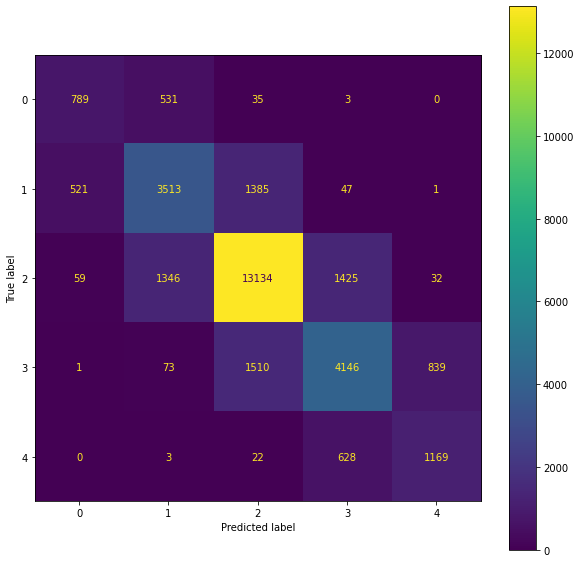

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

val_pred_max=[np.argmax(i) for i in val_prediction['Sentiment']]
val_actual_max=[np.argmax(i) for i in y_val]

report = classification_report(val_pred_max, val_actual_max)

print(report)


Co = confusion_matrix(val_actual_max, val_pred_max, labels=range(5))
cmp = ConfusionMatrixDisplay(Co, display_labels=np.arange(5))
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)

In [ ]:
x_test = tokenizer(
          text=test['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=52,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

label_predicted = model_loaded.predict(
    x={'input_ids': x_test['input_ids']},
)

label_pred_max=[np.argmax(i) for i in label_predicted['Sentiment']]

In [ ]:
print(label_pred_max)

[2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 3, 2, 3, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 2, 2, 2, 1, 2, 2, 2, 2, 3, 3, 2, 3, 4, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 2, 4, 3, 4, 2, 2, 4, 4, 3, 3, 2, 3, 2, 1, 1, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 1, 2, 2, 4, 2, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 1, 2, 3, 4, 2, 1, 3, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 

In [ ]:
test_id = test['PhraseId']

submission = pd.DataFrame(list(zip(test_id, label_pred_max)),
               columns =['PhraseId', 'Sentiment'])
submission.head(20)

submission.to_csv('/content/drive/MyDrive/Colab/submission_roBERTa.csv', index=False)

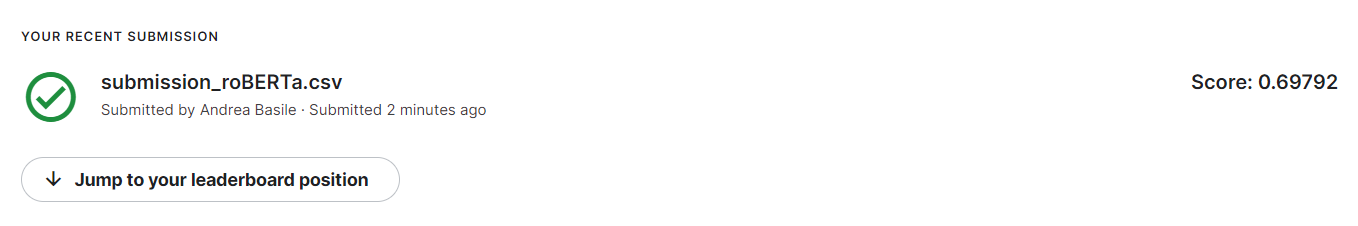

In [ ]:
#Esempio su una recensione presa da IMDB
phrase = "I was a bit skeptical about the concept behind this show. What saves it from banality is just how creative and edgy each episode is. The viewer has NO idea what is going to happen next. There is no formula and the tension is often ratcheded up to excruciating levels. There are tons of laughs here and the back stories are woven in expertly. So many comedies are played very hammy with lots of stereotypes. This is a very refreshing new form of comedy where the backdrop is more realistic with only some of the characters being over the top. If you're a fan of Louie, The Office or Curb Your Enthusiasm you will likely really love this show. It's fresh and Andy Daly plays the role of the hapless reporter to perfection. I hope that we see more hilarious comedies coming. Great stuff!"
encoded_input = tokenizer(
          text = phrase,
          add_special_tokens=True,
          max_length=52,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False)

label = ["negative", "somewhat negative", "neutral", "somewhat positive", "positive"]
score = model_loaded.predict( x = {'input_ids': encoded_input["input_ids"] })
print(label[np.argmax(score["Sentiment"])])

somewhat positive
